In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tesorflow

In [5]:
df = pd.read_csv('gdp_population_with_lags.csv')

Data loaded successfully!
Dataset shape: (5832, 11)

First few rows:
  Country Name Country Code  Year           GDP  Population     GDP_lag_1  \
0      Albania          ALB  1983  1.881413e+09   2843960.0  1.861163e+09   
1      Albania          ALB  1984  1.857338e+09   2904429.0  1.881413e+09   
2      Albania          ALB  1985  1.897050e+09   2964762.0  1.857338e+09   
3      Albania          ALB  1986  2.097326e+09   3022635.0  1.897050e+09   
4      Albania          ALB  1987  2.080796e+09   3083605.0  2.097326e+09   

      GDP_lag_2     GDP_lag_3  GDP_growth_1yr  Population_growth_1yr  \
0  1.808177e+09  1.578102e+09        0.010880                    NaN   
1  1.861163e+09  1.808177e+09       -0.012796                60469.0   
2  1.881413e+09  1.861163e+09        0.021381                60333.0   
3  1.857338e+09  1.881413e+09        0.105572                57873.0   
4  1.897050e+09  1.857338e+09       -0.007881                60970.0   

   GDP_per_capita  
0      661.5467

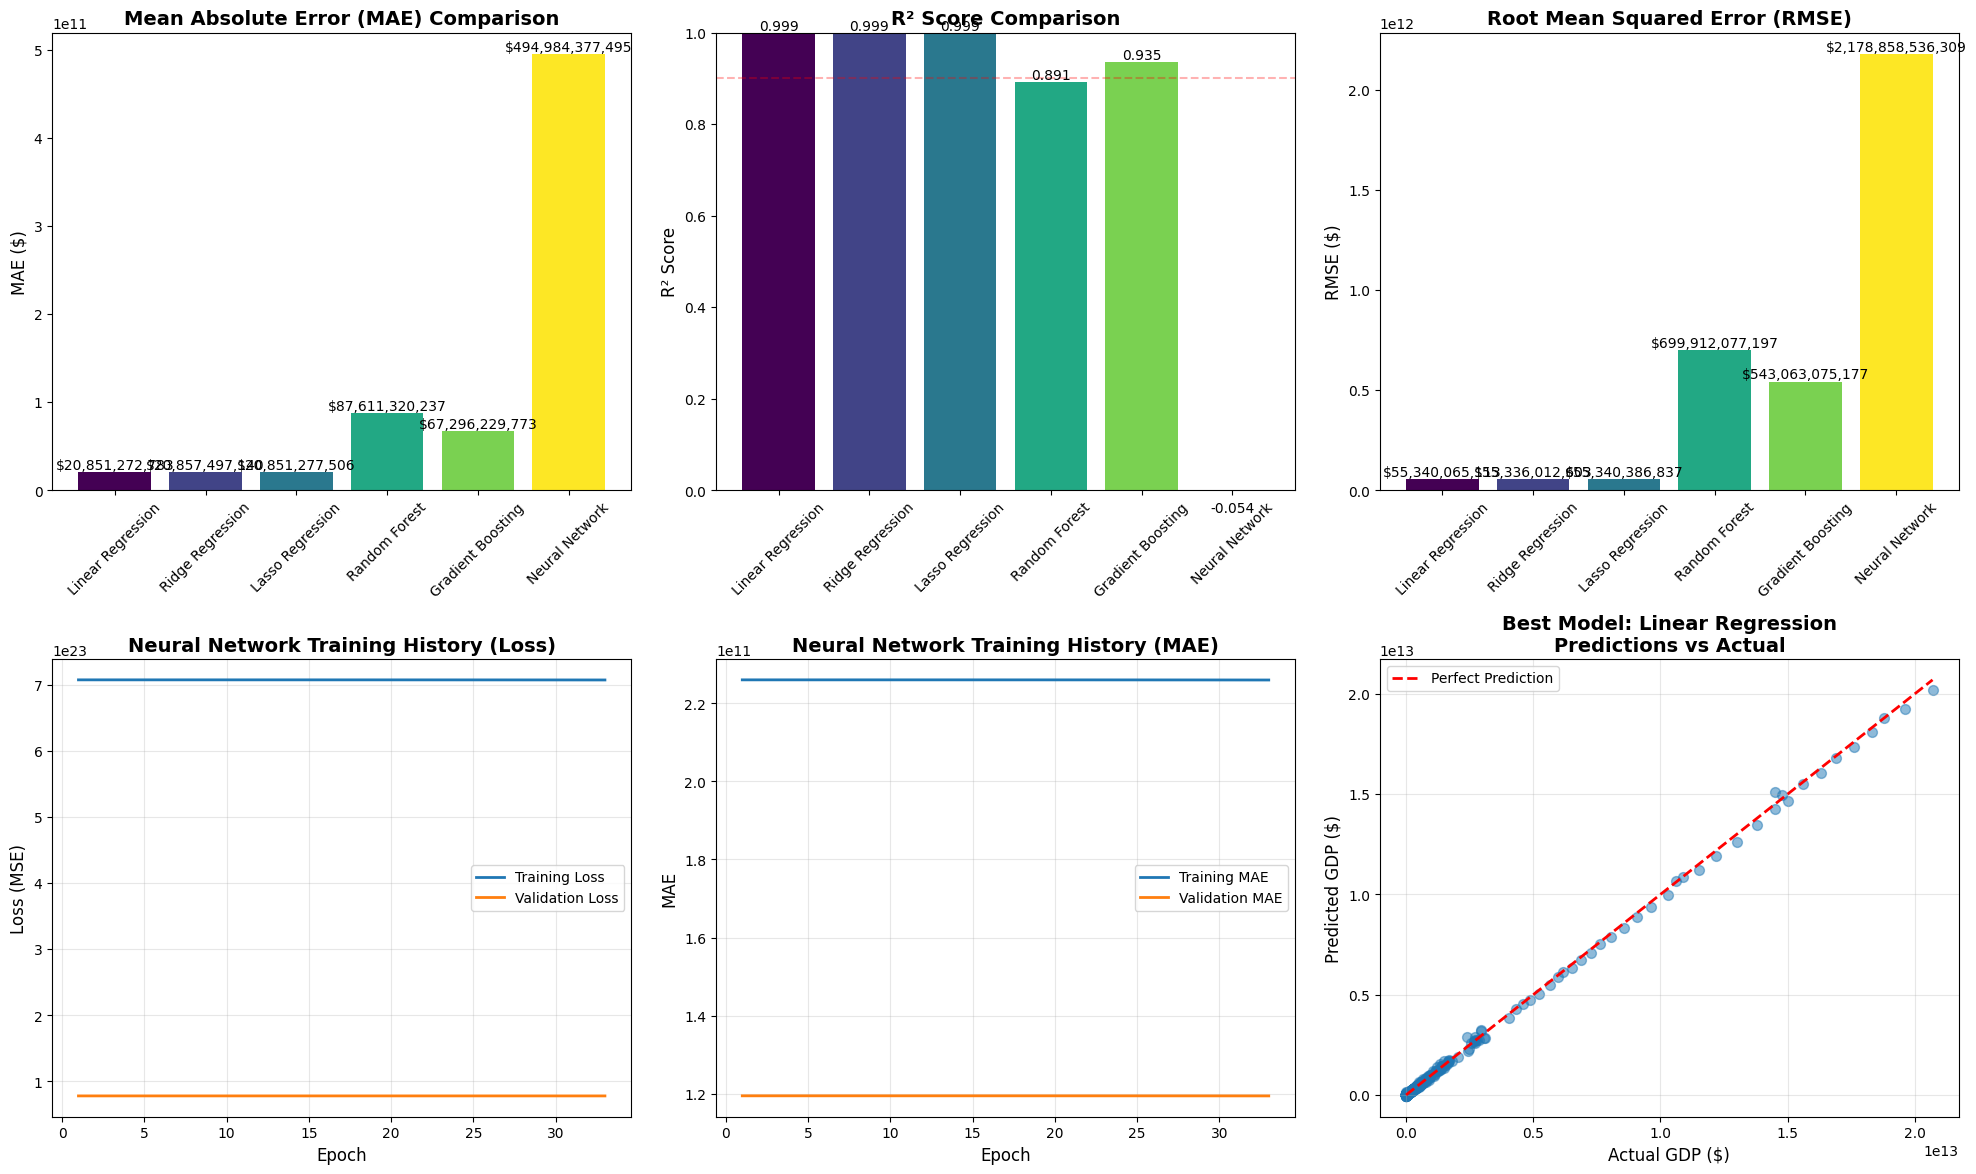

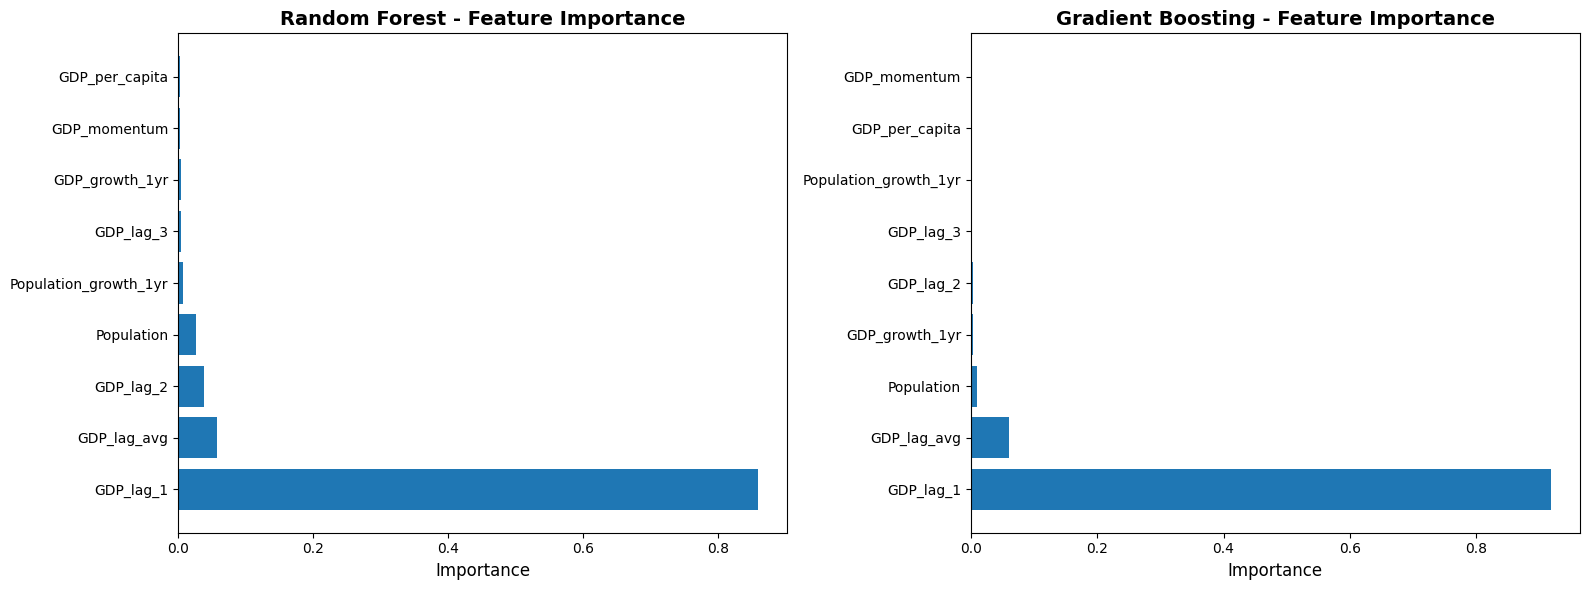


FINAL SUMMARY

 Model Performance Ranking (by MAE):
            Model          MAE         RMSE        R²
Linear Regression 2.085127e+10 5.534007e+10  0.999320
 Lasso Regression 2.085128e+10 5.534039e+10  0.999320
 Ridge Regression 2.085750e+10 5.533601e+10  0.999320
Gradient Boosting 6.729623e+10 5.430631e+11  0.934514
    Random Forest 8.761132e+10 6.999121e+11  0.891223
   Neural Network 4.949844e+11 2.178859e+12 -0.054166

 Best Model: Linear Regression
   MAE: $20,851,272,782.56
   R²: 0.9993

 Recommendations:
1. Use the best performing model for predictions
2. Consider ensemble methods combining top performers
3. For time-series data, consider ARIMA or LSTM models
4. Cross-validate with TimeSeriesSplit for robustness
5. Monitor predictions for different countries/regions separately


In [6]:
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, LSTM
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except:
    KERAS_AVAILABLE = False
    print("TensorFlow not available. Will skip neural network models.")

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

# Load your data
# df = pd.read_csv('your_data.csv')

# For demonstration, creating sample data structure
# Replace this with your actual data loading
# df = pd.read_csv('your_file.csv')

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# ============================================================================
# STEP 2: FEATURE ENGINEERING AND DATA PREPARATION
# ============================================================================

# Handle missing values
df = df.dropna()

# Sort by country and year for time series
df = df.sort_values(['Country Name', 'Year'])

# Create additional features
df['GDP_lag_avg'] = df[['GDP_lag_1', 'GDP_lag_2', 'GDP_lag_3']].mean(axis=1)
df['GDP_momentum'] = df['GDP_lag_1'] - df['GDP_lag_2']

# Select features for modeling
feature_cols = ['Population', 'GDP_lag_1', 'GDP_lag_2', 'GDP_lag_3', 
                'GDP_growth_1yr', 'Population_growth_1yr', 'GDP_per_capita',
                'GDP_lag_avg', 'GDP_momentum']

X = df[feature_cols]
y = df['GDP']

print("\nFeatures being used:")
print(feature_cols)

# ============================================================================
# STEP 3: TRAIN-TEST SPLIT
# ============================================================================

# Time-based split (last 20% for testing)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 4: MODEL TRAINING AND EVALUATION
# ============================================================================

results = {}

def evaluate_model(name, y_true, y_pred):
    """Calculate and store evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R² Score: {r2:.4f}")
    
    return mae, rmse, r2

print("\n" + "="*70)
print("MODEL TRAINING AND EVALUATION")
print("="*70)

# Model 1: Linear Regression
print("\n[1/6] Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
evaluate_model('Linear Regression', y_test, lr_pred)

# Model 2: Ridge Regression
print("\n[2/6] Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
evaluate_model('Ridge Regression', y_test, ridge_pred)

# Model 3: Lasso Regression
print("\n[3/6] Training Lasso Regression...")
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
evaluate_model('Lasso Regression', y_test, lasso_pred)

# Model 4: Random Forest
print("\n[4/6] Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
evaluate_model('Random Forest', y_test, rf_pred)

# Model 5: Gradient Boosting
print("\n[5/6] Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
evaluate_model('Gradient Boosting', y_test, gb_pred)

# Model 6: Neural Network (if TensorFlow available)
if KERAS_AVAILABLE:
    print("\n[6/6] Training Neural Network...")
    
    # Build model
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = nn_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    nn_pred = nn_model.predict(X_test_scaled, verbose=0).flatten()
    evaluate_model('Neural Network', y_test, nn_pred)
    
    # Store history for plotting
    results['Neural Network']['history'] = history.history

# ============================================================================
# STEP 5: VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Model Comparison - MAE
ax1 = plt.subplot(2, 3, 1)
models = list(results.keys())
maes = [results[m]['MAE'] for m in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars = ax1.bar(models, maes, color=colors)
ax1.set_title('Mean Absolute Error (MAE) Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('MAE ($)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# 2. Model Comparison - R²
ax2 = plt.subplot(2, 3, 2)
r2s = [results[m]['R2'] for m in models]
bars = ax2.bar(models, r2s, color=colors)
ax2.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_ylim([0, 1])
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='0.9 threshold')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Model Comparison - RMSE
ax3 = plt.subplot(2, 3, 3)
rmses = [results[m]['RMSE'] for m in models]
bars = ax3.bar(models, rmses, color=colors)
ax3.set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
ax3.set_ylabel('RMSE ($)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# 4. Neural Network Training History (if available)
if KERAS_AVAILABLE and 'Neural Network' in results and 'history' in results['Neural Network']:
    ax4 = plt.subplot(2, 3, 4)
    history = results['Neural Network']['history']
    epochs_range = range(1, len(history['loss']) + 1)
    ax4.plot(epochs_range, history['loss'], label='Training Loss', linewidth=2)
    ax4.plot(epochs_range, history['val_loss'], label='Validation Loss', linewidth=2)
    ax4.set_title('Neural Network Training History (Loss)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Loss (MSE)', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(epochs_range, history['mae'], label='Training MAE', linewidth=2)
    ax5.plot(epochs_range, history['val_mae'], label='Validation MAE', linewidth=2)
    ax5.set_title('Neural Network Training History (MAE)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.set_ylabel('MAE', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
else:
    ax4 = plt.subplot(2, 3, 4)
    ax4.text(0.5, 0.5, 'Neural Network\nNot Available', 
             ha='center', va='center', fontsize=14)
    ax4.axis('off')
    
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')

# 5. Predictions vs Actual (Best Model)
ax6 = plt.subplot(2, 3, 6)
best_model = min(results.keys(), key=lambda x: results[x]['MAE'])
best_pred = results[best_model]['predictions']
ax6.scatter(y_test, best_pred, alpha=0.5, s=50)
ax6.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax6.set_title(f'Best Model: {best_model}\nPredictions vs Actual', 
              fontsize=14, fontweight='bold')
ax6.set_xlabel('Actual GDP ($)', fontsize=12)
ax6.set_ylabel('Predicted GDP ($)', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gdp_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 6: FEATURE IMPORTANCE (for tree-based models)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=12)

# Gradient Boosting Feature Importance
gb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(gb_importance['feature'], gb_importance['importance'])
axes[1].set_title('Gradient Boosting - Feature Importance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=12)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 7: SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

results_df = pd.DataFrame({
    'Model': models,
    'MAE': [results[m]['MAE'] for m in models],
    'RMSE': [results[m]['RMSE'] for m in models],
    'R²': [results[m]['R2'] for m in models]
}).sort_values('MAE')

print("\n Model Performance Ranking (by MAE):")
print(results_df.to_string(index=False))

print(f"\n Best Model: {best_model}")
print(f"   MAE: ${results[best_model]['MAE']:,.2f}")
print(f"   R²: {results[best_model]['R2']:.4f}")

print("\n Recommendations:")
print("1. Use the best performing model for predictions")
print("2. Consider ensemble methods combining top performers")
print("3. For time-series data, consider ARIMA or LSTM models")
print("4. Cross-validate with TimeSeriesSplit for robustness")
print("5. Monitor predictions for different countries/regions separately")

NameError: name 'predictions' is not defined

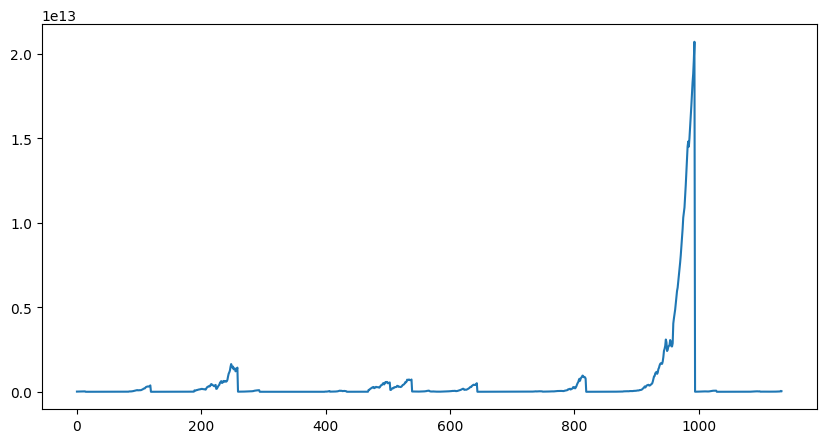

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual GDP")
plt.plot(predictions.values, label="Predicted GDP")
plt.legend()
plt.title("GDP Prediction vs Actual")
plt.show()
